<img src="https://iispi.com.ar/wp-content/themes/iispi/img/logosfooter-05.png" width="600"> <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSyQ946reluo38hvW_laUQJasxSZ3hQGVvytmH3KDWHoEEmBKQKw3FNatXU16cHq4a0eCo&usqp=CAU" width="200"> 

<h1 style='text-align: center;'><font size= '5'>Machine Learning e Imágenes en Python (2022)</h1></font> 

# <center> Automatización del conteo de unidades formadoras de colonias bacterianas

<h1 style='text-align: left;'><font size= '4'>· Benelli Federico</h1></font> 
<h1 style='text-align: left;'><font size= '4'>· Rovezzi Juan Pablo</h1></font> 
<h1 style='text-align: center;'><font size= '2'>Dra. Valeria Rulloni - Dra. Ana Carolina Maldonado</h1></font> 

# Introducción
Sobre esta temática hay que responder algunos interrogantes...
- ¿Qué es el conteo de unidades formadoras de colonias bacterianas (UFC/CFU)?
- ¿En qué consiste?
- ¿Cómo podemos mejorar la técnica?

<img src="Material/draw-petriwagar.png" width="200"><img src="Material/draw_petriwbacteria.jpg" width="200"><img src="Material/draw_petriwhand.jpg" width="200">



## Objetivo:
Diseñar una herramienta de cuantificacion de UFC a partir de fotografias tomadas en plano cenital de capsulas de petri sobre superficies de algun color sólido con el fin de aplicar los conocimientos enseñados y herramientas adquiridas en este curso.
<center> <img src="Material/Petri-A.jpg" width="200">
<h1 style='text-align: center;'><font size= '2'>Figura 1</h1></font> 

# Metodología
Para realizar el conteo de UFCs de una manera automatizada se utilizó un enfoque de entrenamiento semi-
supervisado, utilizando un modelo K-Nearest Neighbors (KNN). La implementación fue realizada en Python,
con soporte de las librerías opencv, matplotlib, pandas, numpy y sklearn.
Para llevarlo a cabo se requirieron 3 etapas:
- Carga de imágen y preprocesamiento
- Entrenamiento de modelo y categorización de datos
- Conteo de UFCs

<center> <img src="https://img.freepik.com/vector-gratis/ilustracion-icono-doodle-engranaje_53876-5596.jpg" width="200"> 

## Librerias

In [7]:
# Numpy para calculo vectorial
import numpy as np
import math
# cv2 para trabajar con imagenes
import cv2

# matplotlib para graficar
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

# Pandas para manipular datos
import pandas as pd

# sklearn para machine learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import BisectingKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing, decomposition
# 
from IPython.display import clear_output 
from collections import Counter
from ipywidgets import interact, widgets

# Nuestra propia libreria de funciones
from Modulos.funciones import *

# Parametros por defecto de matplotlib
plt.rcParams['figure.figsize'] = [5, 5]

## Funciones

# Carga de imágen a analizar y preprocesamiento

Partiendo de una imagen similar a la Figura 1, se selecciona un área que representa específicamente a la cápsula de petri, una vez seleccionada se extrae además una subárea correspondiente a una serie de colonias que se desea contabilizar. Posteriormente se realiza un recorte del área exterior a la cápsula, con el fin de facilitar la categorización posterior al tener una imagen más limpia.
<center> <img src="Material/figura2.jpg" width="500">
<h1 style='text-align: center;'><font size= '2'>Figura 2</h1></font> 

In [8]:
input_path = "Ejemplo/input.jpg"

In [9]:
image = cv2.imread(input_path)

print("Resolucion inicial:",image.shape)

if image.shape >= (400,400,3):
    # Reducir el tamaño de imagen para agilizar el proceso
    image = cv2.resize(image,(400,400)) 

print("Resolucion resultante:",image.shape)

print("La imagen es almacenada como:", type(image))
print("Y los datos cargados dentro son:", type(image[0,0,0]))

Resolucion inicial: (1024, 1024, 3)
Resolucion resultante: (400, 400, 3)
La imagen es almacenada como: <class 'numpy.ndarray'>
Y los datos cargados dentro son: <class 'numpy.uint8'>


Se solicita al usuario seleccionar el area que ocupa la placa de Petri

In [10]:
# Selección de cápsula de petri
petri, petri_range = get_area(image, "Select Petri")
cv2.destroyWindow('Select Petri')

# Selección de colonia para etiquetar
desired_colony, colony_range = get_area(image, "Select Colony")
cv2.destroyWindow('Select Colony')

ny, nx, _ = petri.shape

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


In [11]:
# Guardado de imagenes en otra parte, para tener acceso ante cualquier
# eventualidad
cv2.imwrite("tmp_petri.jpg", petri)
cv2.imwrite("tmp_desired_colony.jpg", desired_colony)

True

In [12]:
# Conversión de imagen BGR a RGB
petri = cv2.cvtColor(petri, cv2.COLOR_BGR2RGB)
desired_colony = cv2.cvtColor(desired_colony, cv2.COLOR_BGR2RGB)
gray_petri = cv2.cvtColor(petri, cv2.COLOR_BGR2GRAY)

# Generación de DataFrames con las imágenes
df_petri = gen_df(petri)
df_desired = gen_df(desired_colony)

### Recortar exterior
Una vez teniendo la sección de la placa de Petri, se realiza un recorte de la 
zona exterior a la cápsula, asumiendo que la misma está representada como un
círculo perfecto (foto tomada de manera totalmente perpendicular y alineada
al centro de la placa)

In [14]:
interact(
    mkcircle_petri,
    offset=widgets.IntSlider(
        min=-petri.shape[0]*1.1,
        max=petri.shape[0]*1.1,
        step=1,
        value=-petri.shape[0]*10,
        layout=widgets.Layout(width='500px')
    ),
    background=widgets.IntSlider(
        min=0, 
        max=255,
        step=255, value=0,layout=widgets.Layout(width='200px')),
)

interactive(children=(IntSlider(value=-440, description='offset', layout=Layout(width='500px'), max=440, min=-…

<function Modulos.funciones.mkcircle_petri(offset, background)>

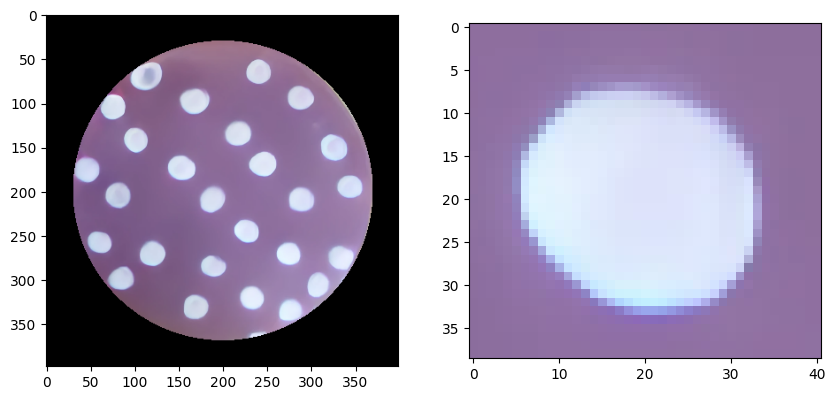

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax[0].imshow(petri)
ax[1].imshow(desired_colony)

# Clusterizacion con KNN

## Binarización de colonia de interés

Como primer etapa, se binariza el recorte de entrenamiento de la imagen original
con el objetivo de aislar la región que compone a la colonia de interés.

Para realizar esto se utiliza un threshold, variando límite inferior y superior
hasta llegar a una separación adecuada.

Durante esta etapa también se muestra la imagen original al mismo tiempo que la
de binarización de manera superpuesta, con el objetivo de facilitar la correcta
selección de los límites.

In [32]:

# Obtención 
interact(
    set_threshold,
    thresh_min=widgets.IntSlider(min=0, max=255, step=1, value=0),
    thresh_max=widgets.IntSlider(min=0, max=255, step=1, value=0)
)



interactive(children=(IntSlider(value=0, description='thresh_min', max=255), IntSlider(value=0, description='t…

<function __main__.set_threshold(thresh_min, thresh_max)>

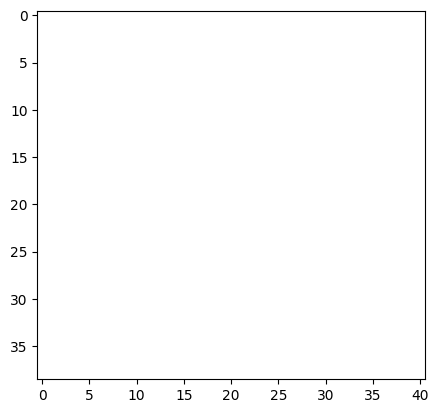

In [33]:
# Binarizar colonia deseada ocn los valores seteados
desired_gray = cv2.cvtColor(desired_colony, cv2.COLOR_BGR2GRAY)
desired_bin = ((thresh_min_out < desired_gray) & (desired_gray < thresh_max_out)) * 1
plt.imshow(desired_bin)

In [34]:
df_desired["label"] = desired_bin.flatten()
df_desired

,fila,columna,b,g,r,label
0,0,0,142,110,158,0
1,0,1,142,110,158,0
2,0,2,142,110,158,0
3,0,3,142,110,158,0
4,0,4,142,110,158,0
...,...,...,...,...,...,...
1594,38,36,144,112,161,0
1595,38,37,144,112,161,0
1596,38,38,144,112,161,0
1597,38,39,143,113,161,0


## Entrenamiento KNN
Una vez definido el DataFrame con los datos catalogados se procede a entrenar un
modelo clasificador para detectar la colonia deseada. Como modelo se eligió
K-Nearest Neighbours (KNN), debido a que las colonias se tratan de datos 
agrupados por regiones.

In [35]:
knn = KNeighborsClassifier(n_neighbors=20, weights="distance")
knn.fit(df_desired.iloc[:, 2:-1], df_desired["label"])

KNeighborsClassifier(n_neighbors=20, weights='distance')

## Predicción en todo el set de datos
Una vez teniendo el modelo entrenado se realiza la predicción en toda la imagen.

Cluster:  0


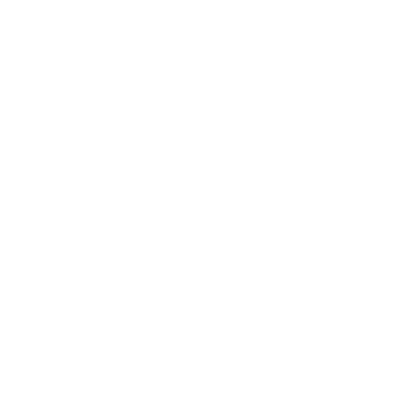

In [36]:
# Genero dataframe de la imagen original (recortada)
df_petri = gen_df(petri)

# Prediccion con KMeans entrenada
labels = knn.predict(df_petri.iloc[:, 2:])
df_petri["labels"] = labels

for label in df_petri["labels"].unique():
    print("Cluster: ", label)
    colonies = (df_petri["labels"].values.reshape((ny, nx)) == label) * 1
    plt.imshow(colonies)
    plt.axis('off')
    plt.set_cmap(cmap="binary")
    plt.axis('off')
    plt.show()

# Conteo de número de UFCs

Para el conteo de UFCs se implementaron dos métodos:

- Relaciones de áreas
- Conteo de puntos

### Relaciones de áreas

Sabiendo el número de colonias en el recorte realizado se calcula el área
promedio que corresponde a una colonia. El área se mide en unidades de pixeles
y el área promedio se determina según:

$\frac{N_{pixeles totales}}{N_{colonias}}$

In [37]:
# Cantidad de colonias en el recorte de clasificación
n_desired = 2

# Determinación de area promedio
area = len(df_desired[df_desired["label"] == label])
mean_area = area/n_desired

if mean_area <= 0:
    raise Exception("Ajustar la Binarización de la Colonia")

# Determinación de número de colonias
n_colonies = len(df_petri[df_petri["labels"] == label])/mean_area

print(f"Hay {math.ceil(n_colonies)} colonias")

Hay 199 colonias


In [38]:
ResultingList = [0]*cluster_quantity
#for i in range(0,cluster_quantity,1):
for i in list(range(cluster_quantity)):
    img = cv2.imread("Colonies"+str(i)+".png", cv2.IMREAD_GRAYSCALE)
    #img = cv2.imread("Colonies"+"1"+".png", cv2.IMREAD_GRAYSCALE)
    countx = 0
    county = 0
    #print(img[int(405/2)])
    #print(img.shape)
    #Pintar recuadro blanco
    for k in list(range(0,img.shape[1]-1)):
        if (img[int(img.shape[0]/2),k] == 255):
            countx+=1
        else: break
    for j in list(range(0,img.shape[0]-1)):
        if (img[j,int(img.shape[1]/2)] == 255):
            county+=1
        else: break

    if countx <=10:
        for m in list(range(0,img.shape[0]-1)):
            img[m,:10] = 0
            img[m,-10:] = 0
        for n in list(range(0,img.shape[1]-1)):
            img[:10,n] = 0
            img[-10:,n] = 0
    #print(img.shape)
    #Invertir colores:
    for r in list(range(0,img.shape[1]-1)):
        for s in list(range(0,img.shape[0]-1)):
            if (img[s,r] == 255):
                img[s,r] = 0
            else:
                img[s,r] = 255



    #cv2.imshow("1",img)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

    seed_pt = (0, 0)
    fill_color = 0
    mask = np.zeros_like(img)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    for th in range(60, 120):
        prev_mask = mask.copy()
        mask = cv2.threshold(img, th, 255, cv2.THRESH_BINARY)[1]
        mask = cv2.floodFill(mask, None, seed_pt, fill_color)[1]
        mask = cv2.bitwise_or(mask, prev_mask)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        #mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    n_centers = cv2.connectedComponents(mask)[0] - 1
    #n_centers = cv2.connectedComponentsWithAlgorithm(mask,8,cv2.CV_32S,0)[0] - 1
    print(n_centers)
    ResultingList[i] = n_centers 
ResultingList = sorted(ResultingList)


print(ResultingList)
#print('Hay %d colonias.'%ResultingList[int((cluster_quantity-1))])
if cluster_quantity == 2:
    print('Hay %d colonias.'%ResultingList[int((cluster_quantity-1))])
else:
    print('Hay %d colonias.'%ResultingList[int((cluster_quantity-1)/2)])

#https://stackoverflow.com/questions/47566093/computer-vision-counting-small-circles-in-an-image

NameError: name 'cluster_quantity' is not defined